Combined signal mean: 1.2405743066736603
Freq range: 0.0 to 498.0


/Users/elaine/spectral-decomposition/spectral_decomposition/__init__.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


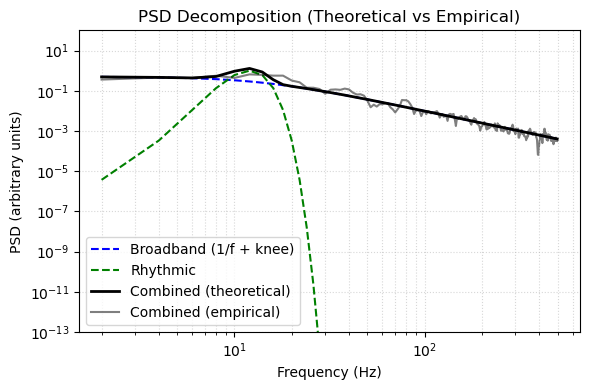

In [185]:
# Simulate data

from spectral_decomposition import spectrum

res = spectrum(
    sampling_rate=1000,
    duration=0.5,
    aperiodic_exponent=2.0,
    aperiodic_offset=2.0,
    knee=200,
    peaks=[{'freq':12.0, 'amplitude': 1.0, 'sigma': 2.0}],
    average_firing_rate=0.0,
    random_state=42,
    direct_estimate=True,
    plot=True
)

# Access time-domain signals
td = res.time_domain
print("Combined signal mean:", td.combined_signal.mean())

# Access freq-domain data
fd = res.frequency_domain
print("Freq range:", fd.frequencies[0], "to", fd.frequencies[-1])

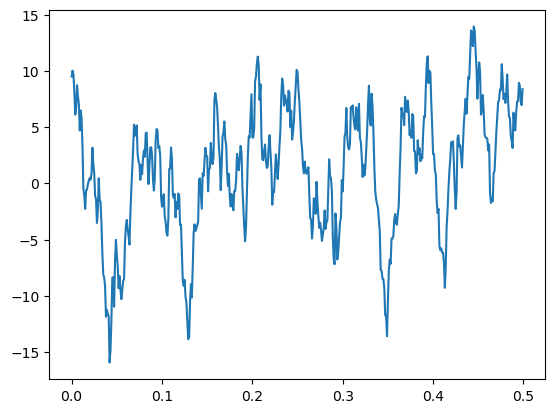

In [186]:
# This is what the signal looks like!

import matplotlib.pyplot as plt

signal = td.combined_signal
time = td.time

plt.plot(time, signal)
plt.show()

In [187]:
# Single taper

from scipy.signal import welch

def single_taper_psd(signal, window, fs=1000, window_length=None, overlap=0):
    N = len(signal)
    nperseg = N if window_length is None else int(window_length * fs) # number of samples per segment
    noverlap = int(nperseg * overlap) # number of samples per overlap

    freqs, psd = welch(signal,
                       fs=fs,
                       window=window,
                       nperseg=nperseg,
                       noverlap=noverlap,
                       scaling='density' # return psd
                       )

    return freqs, psd

In [188]:
# Multitaper (not yet scaled)
import numpy as np
from scipy.signal.windows import dpss
from scipy.fft import fft, fftfreq

def multitaper_psd(signal, fs=1000, NW=2, K=None):
    N = len(signal)  

    # deafult to 2*NW - 1 tapers
    K = K or int(2 * NW - 1)

    # create dpss tapers
    tapers = dpss(N, NW, K)  # shape: (K, N)

    # Apply each taper to the signal
    tapered_signals = np.array([signal * taper for taper in tapers])  # shape: (K, N)

    fft_sum = np.sum(np.abs(fft(tapered_signals, axis=1))**2, axis=0)  # summed PSD across tapers; power = |FFT|^2

    psd = fft_sum / K  # Average PSD
    freqs = fftfreq(N, d=1/fs)

    return freqs[freqs >= 0], psd[freqs >= 0] # only want positive frequencies

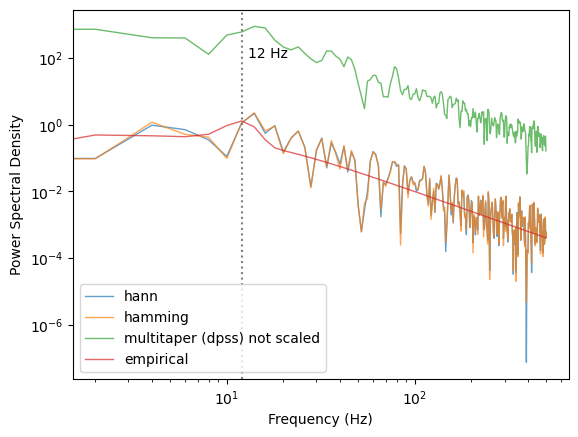

In [189]:
# Plotting...

freq_hann, psd_hann = single_taper_psd(signal, 'hann')
freq_hamming, psd_hamming = single_taper_psd(signal, 'hamming')
freq_mt, psd_mt = multitaper_psd(signal)

plt.loglog(freq_hann, psd_hann, linewidth=1, alpha=0.7, label='hann')
plt.loglog(freq_hamming, psd_hamming, linewidth=1, alpha=0.7, label='hamming')
plt.loglog(freq_mt, psd_mt, linewidth=1, alpha=0.7, label='multitaper (dpss) not scaled')
plt.plot(fd.frequencies, fd.combined_spectrum, linewidth=1, alpha=0.7, label='empirical')

plt.axvline(x=12, color='gray', linestyle=':', linewidth=1.5)
plt.text(13, 100,'12 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()